In [13]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('future.no_silent_downcasting', True)

# Add in text formatting
BOLD = '\033[1m'  # ANSI escape sequence for bold
END = '\033[0m'   # ANSI escape sequence to reset formatting
import pprint
pp = pprint.PrettyPrinter(indent = 4)

In [14]:
# Import and clean up dataset
df = pd.read_csv('data/electric_vehicles_spec_2025.csv')
df = df.dropna()
df.head()

,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,...,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url
0,Abarth,500e Convertible,155,37.8,Lithium-ion,192.0,235.0,156,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1904/Abarth-500e-C...
1,Abarth,500e Hatchback,155,37.8,Lithium-ion,192.0,235.0,149,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1903/Abarth-500e-H...
2,Abarth,600e Scorpionissima,200,50.8,Lithium-ion,102.0,345.0,158,280,5.9,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3057/Abarth-600e-S...
3,Abarth,600e Turismo,200,50.8,Lithium-ion,102.0,345.0,158,280,6.2,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3056/Abarth-600e-T...
6,Alfa,Romeo Junior Elettrica 54 kWh,150,50.8,Lithium-ion,102.0,260.0,128,320,9.0,...,0.0,400,5,FWD,JB - Compact,4173,1781,1532,SUV,https://ev-database.org/car/2184/Alfa-Romeo-Ju...


In [15]:
# Check for missing values
df.isnull().sum()

brand                        0
model                        0
top_speed_kmh                0
battery_capacity_kWh         0
battery_type                 0
number_of_cells              0
torque_nm                    0
efficiency_wh_per_km         0
range_km                     0
acceleration_0_100_s         0
fast_charging_power_kw_dc    0
fast_charge_port             0
towing_capacity_kg           0
cargo_volume_l               0
seats                        0
drivetrain                   0
segment                      0
length_mm                    0
width_mm                     0
height_mm                    0
car_body_type                0
source_url                   0
dtype: int64

Using the dataset from Kaggle about electric vehicles - https://www.kaggle.com/datasets/urvishahir/electric-vehicle-specifications-dataset-2025

Description :

This dataset provides a comprehensive collection of specifications and performance metrics for modern electric vehicles (EVs). It is designed to support researchers, analysts, students, and developers working on data science, machine learning, automotive market research, sustainability studies, or electric vehicle adoption analysis.

Each row in the dataset represents a specific electric vehicle model with a rich set of attributes covering:


        Brand and Model: Manufacturer and specific nameplate of the EV.
        Car Body Type: Classification such as hatchback, SUV, sedan, etc.
        Segment: Vehicle segment (e.g., compact, midsize, executive).

        Battery Capacity (kWh): The gross energy capacity of the battery.
        Number of Cells and Battery Type: Technical battery information, where available.
        Efficiency (Wh/km): Power consumption rate of the vehicle.
        Range (km): Estimated driving range on a full charge.

        Fast Charging Power (kW): Maximum supported DC fast-charging power.
        Fast Charge Port Type: Connector standard (e.g., CCS, CHAdeMO).

        Top Speed (km/h): Maximum speed of the vehicle.
        0–100 km/h Acceleration (s): Time to reach 100 km/h from a standstill.
        Torque (Nm): Maximum torque output, where available.

        Towing Capacity (kg): Ability to tow loads, provided where applicable.
        Cargo Volume (L): Luggage space, sometimes approximate or expressed in alternative units.
        Seats: Total seating capacity.
        
        Length, Width, Height (mm): Physical footprint of the vehicle.
        Drivetrain: Powertrain configuration (e.g., AWD, RWD, FWD).
        Source URL: Reference link for each car (used in scraping).

## Question 1: Is there a relationship between the technical qualities? 
Cluster analysis: Are there natural clusters of EVs (e.g., economy commuter, high-performance, luxury long-range) based on specs?
- Unsupervised
- No latent variable
- No clear truth variable
- Perform clustering
- Perform other unsupervised modeling

In [16]:
# Could cluster car brands together based on technical specs: battery size, top speeds, number of cells, etc...
scaler = StandardScaler()
technical_features = df[['top_speed_kmh', 'battery_capacity_kWh', 'number_of_cells', 
                      'torque_nm', 'efficiency_wh_per_km', 'range_km', 'acceleration_0_100_s']].values


technical_features_scaled = scaler.fit_transform(technical_features)

manu = df[['brand']] # Grab brands to group by

In [17]:
# Look for best cluster parameters based on AIC and/or BIC
def best_cluster(X):
    # Initialize parameters
    cluster_range = range(2, 21)
    aic_history = []
    bic_history = []
    models = []
    
    for num_clusters in cluster_range:
        gmm = GaussianMixture(n_components = num_clusters, n_init = 10)
        gmm.fit(X)
    
        aic = gmm.aic(X)
        bic = gmm.bic(X)
    
        aic_history.append(aic) # Append AIC scores
        bic_history.append(bic) # Append BIC scores
        models.append(gmm) # Append models used
    
        print(f"Number of clusters = {num_clusters} with AIC = {aic:.4f}, BIC = {bic:.4f}")
    
    # Find best number of clusters
    aic_min_index = np.argmin(aic_history)
    bic_min_index = np.argmin(bic_history)
    best_aic_cluster = cluster_range[aic_min_index]
    best_bic_cluster = cluster_range[bic_min_index]

    # Depending on the run, sometimes AIC and BIC don't agree
    best_aic_model = models[best_aic_cluster - 2] # minus 2 because we started with range of 2
    best_bic_model = models[best_bic_cluster - 2]
    
    print(f"\nWith a minimum value of {min(aic_history):.4f} AIC, the optimal number of clusters based on AIC is {best_aic_cluster}")
    print(f"With a minimum value of {min(bic_history):.4f} BIC, the optimal number of clusters based on BIC is {best_bic_cluster}")
    return best_aic_model, best_bic_model, best_aic_cluster, best_bic_cluster

# Function to print out clusters and their respective countries through specified evaluator
def brand_clusters(cluster, best_cluster_value, df, evaluator):
    print(BOLD + f'\nGiven a total of {best_cluster_value} clusters through {evaluator}' + END)
    for cluster_number in range(best_cluster_value): # Iterate through each cluster
        brand_in_clusters = df[df[cluster] == cluster_number]['brand'].unique()
        print(f"\nCluster {cluster_number + 1} ({len(brand_in_clusters)} brands):")
        print(', '.join(brand_in_clusters)) # https://stackoverflow.com/questions/22399014/print-elements-in-an-array-with-a-delimiter

In [18]:
# Find best cluster, then group and print out the brands
q1_copy = df.copy() # Create a copy of dataframe for cluster labels
best_aic_model, best_bic_model, best_aic_cluster, best_bic_cluster = best_cluster(technical_features_scaled)

# Get cluster labels
aic_cluster_labels = best_aic_model.predict(technical_features_scaled)
bic_cluster_labels = best_bic_model.predict(technical_features_scaled)
q1_copy['AIC Cluster'] = aic_cluster_labels
q1_copy['BIC Cluster'] = bic_cluster_labels

# Print out brands clustered together, based on AIC or BIC
brand_clusters('AIC Cluster', best_aic_cluster, q1_copy, 'AIC')
brand_clusters('BIC Cluster', best_bic_cluster, q1_copy, 'BIC')

Number of clusters = 2 with AIC = 2589.7583, BIC = 2843.6507
Number of clusters = 3 with AIC = 1842.5340, BIC = 2225.1606
Number of clusters = 4 with AIC = 1459.8186, BIC = 1971.1793
Number of clusters = 5 with AIC = 1203.6699, BIC = 1843.7648
Number of clusters = 6 with AIC = 1024.9454, BIC = 1793.7745
Number of clusters = 7 with AIC = 768.1024, BIC = 1665.6656
Number of clusters = 8 with AIC = 597.9279, BIC = 1624.2253
Number of clusters = 9 with AIC = 468.1570, BIC = 1623.1886
Number of clusters = 10 with AIC = 16.8768, BIC = 1300.6426
Number of clusters = 11 with AIC = -28.7342, BIC = 1383.7657
Number of clusters = 12 with AIC = -261.1040, BIC = 1280.1301
Number of clusters = 13 with AIC = -540.9635, BIC = 1129.0047
Number of clusters = 14 with AIC = -285.1264, BIC = 1513.5760
Number of clusters = 15 with AIC = -793.0005, BIC = 1134.4361
Number of clusters = 16 with AIC = -717.9875, BIC = 1338.1832
Number of clusters = 17 with AIC = -722.8317, BIC = 1462.0732
Number of clusters = 1

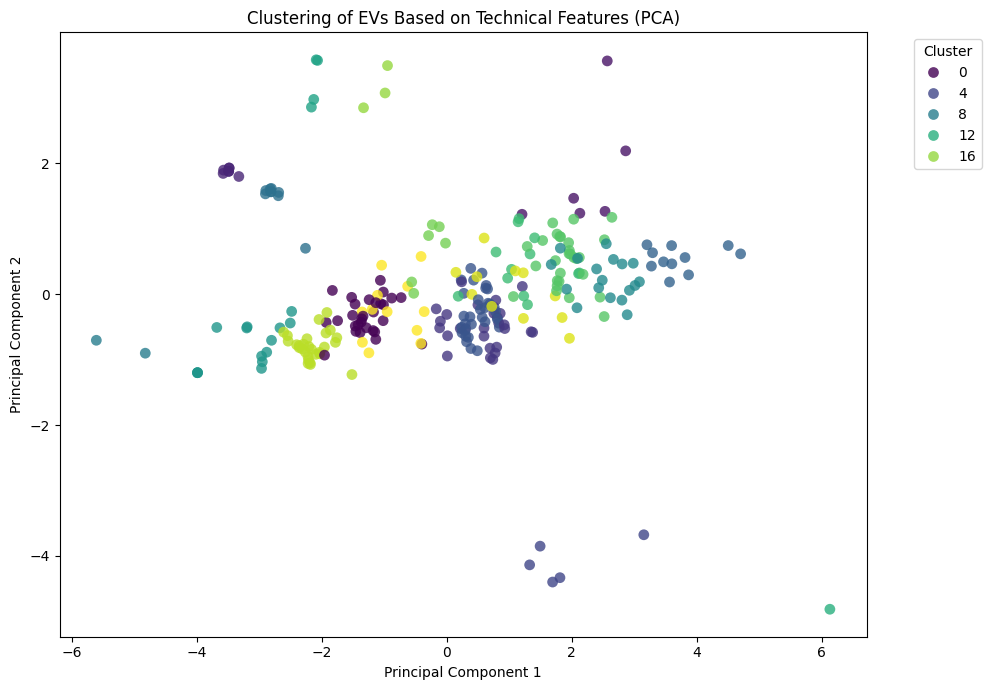

In [19]:
from sklearn.decomposition import PCA
import seaborn as sns

#PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(technical_features_scaled)

#df for plotting
plot_df = pd.DataFrame({
    'PCA1': pca_result[:, 0],
    'PCA2': pca_result[:, 1],
    'Cluster': aic_cluster_labels, 
    'Brand': df['brand']
})

#plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=plot_df,
    x='PCA1', y='PCA2',
    hue='Cluster',
    palette='viridis',
    s=60,
    alpha=0.8,
    edgecolor='none'
)

plt.title('Clustering of EVs Based on Technical Features (PCA)')
plt.xlabel(f'Principal Component 1')
plt.ylabel(f'Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Q1 Temporary Analysis
BIC tends to penalizes model complexity more than AIC. It tends to select simpler models with fewer clusters; therefore BIC is generally preferred to prevent overfitting, and to compress down datasets to have less complexity.

AIC tends to penalizes complexity less, so it will often select models with more clusters. AIC is better when the goal is to predict or when we want a model that captures more nuances in the data.

With our current EM algorithm implementation, we can see this reflected in the number of clusters chosen either via AIC or BIC. AIC consistently chooses more clusters than BIC through multiple runs. Due to brands having different models of cars, we will see brands repeated throughout the clusters. We can still extrapolate information from the groupings (are perceived high-end brands grouped together? etc...)

It's also interesting to see how the clusters are formed with closely related car brands. For example, Polestar is the sister company or EV subsidiary of Volvo. However, they are frequently grouped separately. Is this because Volvo is considered the lower end EV models?

## Question 2: 
- What other factors are closely related to efficiency? What makes an electric car the most efficient?

In [20]:
# Build a function to choose the best X values
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
def best_parameters(X, y, model_type):
    model = None
    score_type = None
    if model_type == LinearRegression:
        model = model_type()
        score_type = 'r2'
    elif model_type == LogisticRegression:
        model = model_type(max_iter = 1000)
        score_type = 'accuracy'

    rfecv = RFECV(estimator = model, step = 1, cv = KFold(5), 
                      scoring = score_type, min_features_to_select = 1)
    rfecv.fit(X, y)
    
    # Results
    print(f"Optimal number of features: {rfecv.n_features_}")
    print(f"Best cross-validation score: {rfecv.cv_results_['mean_test_score'].max()}")
        
    # Get the best selected features
    selected_features = X.columns[rfecv.support_]
    print(f"\nSelected features:")
    print(', '.join(selected_features.tolist()))

    return selected_features

In [21]:
# Grab features
q2_X = df[['top_speed_kmh', 'battery_capacity_kWh', 'number_of_cells', 
           'torque_nm', 'range_km', 'length_mm', 'width_mm',
           'height_mm', 'acceleration_0_100_s', 'seats', 'towing_capacity_kg', 
           'fast_charging_power_kw_dc']]
efficiency_y = df[['efficiency_wh_per_km']]

# Choose the best features to use for predictive modeling
q2_selected_features = best_parameters(q2_X, efficiency_y, LinearRegression)

Optimal number of features: 12
Best cross-validation score: 0.6019965612792273

Selected features:
top_speed_kmh, battery_capacity_kWh, number_of_cells, torque_nm, range_km, length_mm, width_mm, height_mm, acceleration_0_100_s, seats, towing_capacity_kg, fast_charging_power_kw_dc


In [22]:
# Create X and y with respective features
q2_X = df[q2_selected_features]
q2_X = sm.add_constant(q2_X)

# Run statsmodel linear regression model
print(sm.OLS(efficiency_y, q2_X).fit().summary())

                             OLS Regression Results                             
Dep. Variable:     efficiency_wh_per_km   R-squared:                       0.834
Model:                              OLS   Adj. R-squared:                  0.826
Method:                   Least Squares   F-statistic:                     104.9
Date:                  Wed, 12 Nov 2025   Prob (F-statistic):           1.88e-90
Time:                          23:08:57   Log-Likelihood:                -1046.7
No. Observations:                   264   AIC:                             2119.
Df Residuals:                       251   BIC:                             2166.
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

### Q2 Temporary Analysis
Interestingly, even with a high colinearilty shown through the high R squared value, not many of the chosen parameters are statistically significant. If we take a look at the chassis specifications, the length and height are statistically significant while the width is not. Additionally, only battery capacity, number of cells in the battery, the range of the car, and towing capacity in kilograms can help predict the efficiency of the car.

Therefore, parts of the chassis dimensions, battery specifications, range of the vehicle, and overall horsepower of the engine (how much weight it can pull) are the key components when considering effieciency.

Another interesting analysis we could do is to incorporate drive train (using numbers to deliminate what type of drive train). Traditionally, AWD is considered to be less efficient than FWD or RWD in gas cars. Would this also be the case with EVs?

In [23]:
# Question 2 cont.
# Convert unique types of drivetrains to numerical values to run logistic regression or decision tree
# Current drive trains include: FWD, RWD, AWD (Front Wheel Drive, Rear Wheel Drive, All Wheel Drive)

# Convert FWD - 1, RWD - 2, AWD - 3
df_q2 = df.copy()
df_q2['drivetrain'] = df_q2['drivetrain'].replace({'FWD': 1, 'RWD': 2, 'AWD': 3})

q2_feature_list = q2_selected_features.tolist()
q2_feature_list.append('drivetrain')

q2_X = df_q2[q2_feature_list]
q2_X['drivetrain'] = q2_X['drivetrain'].astype(int)
q2_X = sm.add_constant(q2_X) # New dataframe with drive train included


print(sm.OLS(efficiency_y, q2_X).fit().summary())

                             OLS Regression Results                             
Dep. Variable:     efficiency_wh_per_km   R-squared:                       0.834
Model:                              OLS   Adj. R-squared:                  0.825
Method:                   Least Squares   F-statistic:                     96.48
Date:                  Wed, 12 Nov 2025   Prob (F-statistic):           1.92e-89
Time:                          23:08:57   Log-Likelihood:                -1046.7
No. Observations:                   264   AIC:                             2121.
Df Residuals:                       250   BIC:                             2172.
Df Model:                            13                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

/var/folders/h7/3btlfl1n34b8j9c1l_nf2fg80000gn/T/ipykernel_69634/3384196924.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q2_X['drivetrain'] = q2_X['drivetrain'].astype(int)


### Q2 Temporary Analysis cont.
Interestingly, there is a low statistical significance when including drive train as a parameter when trying to predict the efficiency value of the vehicle. Perhaps the drivetrain does not make as big of a difference in EVs compared to gas cars.

Research opportunities:
- https://www.subaruofauburn.com/does-all-wheel-drive-hurt-fuel-economy/
- https://www.louscarcare.com/blog/what-is-the-difference-between-awd-and-4wd

In [24]:
# Q2 cont. - how about seeing if we can make a predictive logistic regression model to guess the drive train type based on efficiency features?
q2_X_efficiency = df[['top_speed_kmh', 'battery_capacity_kWh', 'number_of_cells', 
           'torque_nm', 'range_km', 'length_mm', 'width_mm',
           'height_mm', 'acceleration_0_100_s', 'seats', 'towing_capacity_kg', 
           'fast_charging_power_kw_dc', 'efficiency_wh_per_km']]
q2_X_scaled = pd.DataFrame(scaler.fit_transform(q2_X_efficiency), 
                           columns = q2_X_efficiency.columns, index = q2_X_efficiency.index)
q2_y_drivetrain = df_q2['drivetrain']
q2_y_drivetrain = q2_y_drivetrain.astype(int)

# Find best X selection
best_parameters(q2_X_scaled, q2_y_drivetrain, LogisticRegression)

Optimal number of features: 3
Best cross-validation score: 0.8899129172714078

Selected features:
torque_nm, acceleration_0_100_s, fast_charging_power_kw_dc


Index(['torque_nm', 'acceleration_0_100_s', 'fast_charging_power_kw_dc'], dtype='object')

In [25]:
# Initialize parameters
train_accuracy = []
test_accuracy = []

# Run multiple iterations
for i in range(1000):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        q2_X_scaled, q2_y_drivetrain, test_size = 0.2
    )
    
    # Train the model
    model = LogisticRegression(max_iter = 5000)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluate accuracy
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))

print(f"Average Training Accuracy: {sum(train_accuracy)/len(train_accuracy):.4f}")
print(f"Average Test Accuracy: {sum(test_accuracy)/len(test_accuracy):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

Average Training Accuracy: 0.9431
Average Test Accuracy: 0.9001

Confusion Matrix:
[[17  2  0]
 [ 1 13  0]
 [ 0  1 19]]


### Q2 Temporary Analysis part 3
We can see that through optimal feature selection, only 3 features remain through an accuracy scoring model. These include torque, acceleration and fast charging output. Against what we'd expect, few physical and technical features remain when trying to predict the drive train style. Especially with the lack of efficiency and range as a parameter, it's safe to assume drive train does not play a huge role in determining an EV's range and efficiency performance like it does with normal gas standard cars.

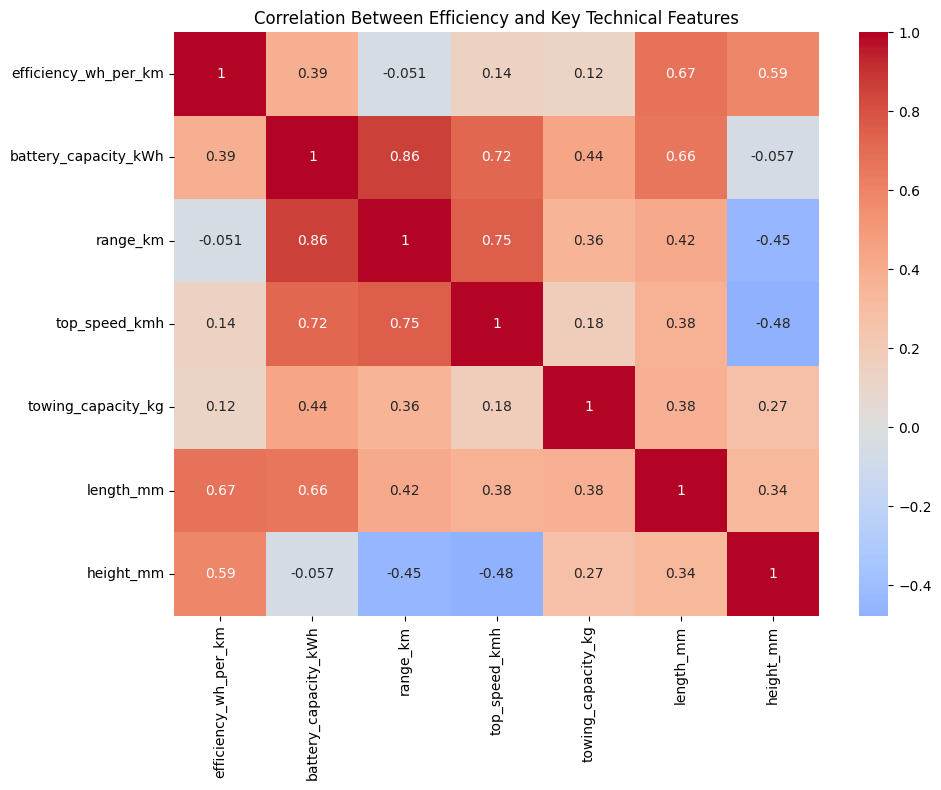

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[['efficiency_wh_per_km', 'battery_capacity_kWh', 'range_km', 
                'top_speed_kmh', 'towing_capacity_kg', 'length_mm', 'height_mm']].corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Efficiency and Key Technical Features')
plt.tight_layout()
plt.show()


## Question 3:

Predictive Modeling

Build a predictive model: Given variables like battery_capacity_kWh, body type, segment, drivetrain, brand, dimensions — can you predict range_km?

Or: Predict fast_charging_power_kW given other specs (battery size, brand, segment) — which vehicles support high charging?

Feature engineering: Create derived metrics like “range per kWh”, “Wh per km per kg volume”, etc.— which features are most predictive of being in “premium” vs “economy” class?

In [26]:
# Predictive modeling function, can we predict range based on technical specs?    
q3_X = df[['top_speed_kmh', 'battery_capacity_kWh', 'number_of_cells', 
                  'torque_nm', 'efficiency_wh_per_km', 'length_mm', 'width_mm',
                  'height_mm', 'acceleration_0_100_s', 'seats', 'towing_capacity_kg', 
                 'fast_charging_power_kw_dc']]


range_y = df[['range_km']]
range_y_scaled = scaler.fit_transform(range_y)

# Choose the best features to use for predictive modeling
selected_features = best_parameters(q3_X, range_y, LinearRegression)

Optimal number of features: 11
Best cross-validation score: 0.9274497315691969

Selected features:
top_speed_kmh, battery_capacity_kWh, number_of_cells, torque_nm, efficiency_wh_per_km, length_mm, width_mm, height_mm, acceleration_0_100_s, seats, fast_charging_power_kw_dc


In [27]:
# Create X and y with respective features
q3_X = df[selected_features]
q3_X = sm.add_constant(q3_X)

# Run statsmodel linear regression model
print(sm.OLS(range_y, q3_X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:               range_km   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     510.2
Date:                Wed, 12 Nov 2025   Prob (F-statistic):          2.97e-165
Time:                        23:09:02   Log-Likelihood:                -1181.1
No. Observations:                 264   AIC:                             2386.
Df Residuals:                     252   BIC:                             2429.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### Q3 Temporary Analysis
With technical specs such as the size of the chassis, battery capacity, number of cells, etc... most seem to be statistically significant (p-value less than 0.05). The only two features that do not hold as much statistical significance are the top speed of the car and the fast charging capacity. Overall with a high R squared value, the linear regression model performs really well with estimating the range of the cars measured in kilometers. If customers are looking at the market in the future and are looking for high performing, efficient EVs, predictive analysis seems to be very performant.

In [28]:
# Extra modeling idea - use logistic regression with classification for "premium" vs "economy" brands
# Group brands together based on a few parameters, only have 2 groups and see if there is a high and low class separation

# Create elbow test to find best k-cluster
def elbow_test(num_k_1, num_k_2, df):
    sse = {}
    k_range = range(num_k_1, num_k_2)
    for k in k_range:
        kmeans = KMeans(n_clusters = k, max_iter = 1000, n_init = 10).fit(df)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title("EV Car Clusters")
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.show()

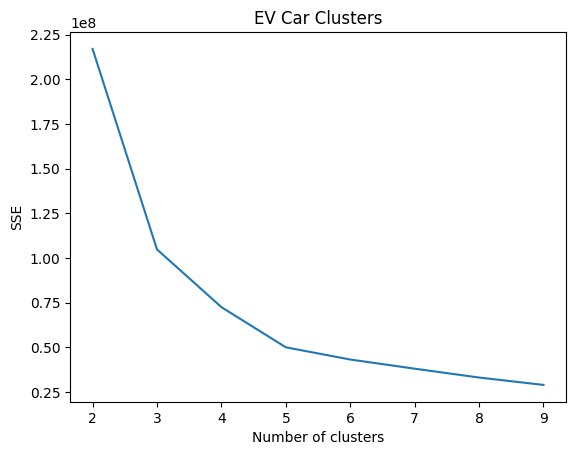

In [29]:
# Prepare dataframe with increased technical specifications
q3_2 = df[['top_speed_kmh', 'battery_capacity_kWh', 'number_of_cells', 
           'torque_nm', 'efficiency_wh_per_km', 'length_mm', 'width_mm',
           'height_mm', 'acceleration_0_100_s', 'seats', 'towing_capacity_kg', 
           'fast_charging_power_kw_dc', 'range_km', 'drivetrain']].copy()

q3_2['drivetrain'] = q3_2['drivetrain'].replace({'FWD': 1, 'RWD': 2, 'AWD': 3})

# Run elbow test
elbow_test(2, 10, q3_2)

#### Elbow Method Analysis
We can see a huge drop of the SSE value at 3 clusters with a leveled out value at 5 clusters. With these values in mind, we can try both 3 and 5.

With 3 clusters, it could be a high, medium, low class of vehicles.

In [30]:
# Run kmeans clustering with k = 3 to find clustering of cars
ev_kmeans = KMeans(n_clusters = 3, n_init = "auto", random_state = 1) # Random state 1 for most consistent data scenarios
ev_labels = ev_kmeans.fit(q3_2).labels_
manu['kmeans cluster'] = ev_labels

# Print out group clusters
brand_clusters('kmeans cluster', 3, manu, 'Kmeans')


Given a total of 3 clusters through Kmeans

Cluster 1 (27 brands):
Abarth, Alfa, Alpine, Audi, BYD, CUPRA, Citroen, DS, Dacia, Fiat, Ford, Hyundai, Jaguar, Jeep, Kia, Lancia, Lexus, MG, Mercedes-Benz, Opel, Peugeot, Porsche, Renault, Skoda, Subaru, Toyota, Volkswagen

Cluster 2 (2 brands):
Lucid, Tesla

Cluster 3 (18 brands):
Audi, BYD, CUPRA, Cadillac, Ford, Genesis, Hyundai, Kia, Mercedes-Benz, NIO, Opel, Peugeot, Polestar, Porsche, Skoda, Volkswagen, Volvo, Zeekr


/var/folders/h7/3btlfl1n34b8j9c1l_nf2fg80000gn/T/ipykernel_69634/1513582284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manu['kmeans cluster'] = ev_labels


### Graphical Reporting

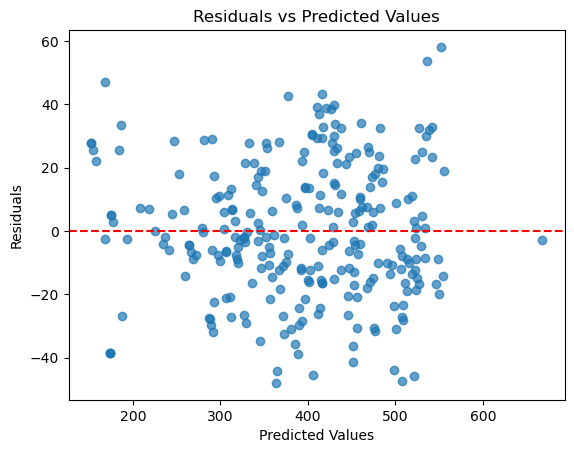

In [25]:
# Plotting the residuals from the linear regression model: 

# Convert range_y to Series
range_y_series = range_y.iloc[:, 0]

# Fit the model
model = sm.OLS(range_y_series, q3_X).fit()

# Predict and calculate residuals
predictions = model.predict(q3_X)

# Calculate residuals
residuals = range_y_series - predictions

# Plot residuals
plt.scatter(predictions, residuals, alpha = 0.7)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

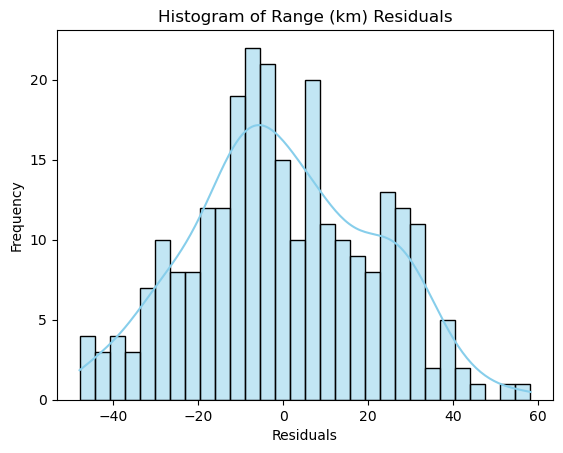

In [22]:
# Histogram to see the distribution of the residuals from the predicted data:

sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.title('Histogram of Range (km) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

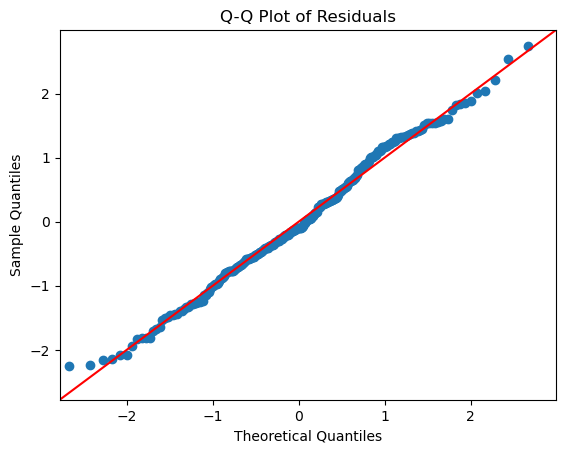

In [20]:
# Created a Q-Q plot of the residuals: 

sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

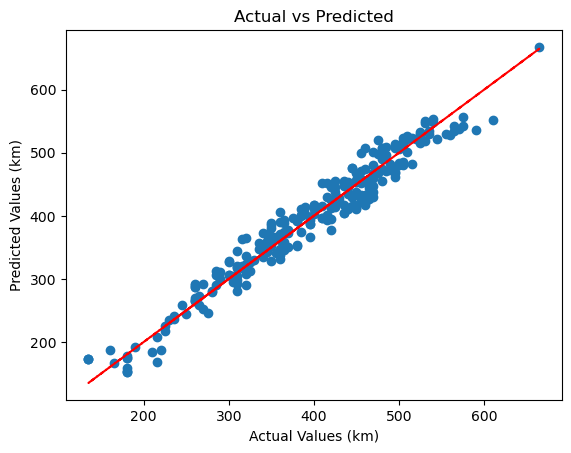

In [26]:
# Scatterplot to compare between the actual and predicted values to the line of best fit:

plt.scatter(range_y_series, predictions)
plt.plot(range_y_series, range_y_series, color='red', linestyle='--')  # ideal fit line
plt.xlabel('Actual Values (km)')
plt.ylabel('Predicted Values (km)')
plt.title('Actual vs Predicted')
plt.show()